# Build a recommender system by using cosine simillarties score.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine, correlation

from sklearn.metrics.pairwise import cosine_similarity

# Import Data and do EDA

In [2]:
book=pd.read_csv("/Users/ayaskantsamal/Documents/EXCELR/assignments/book_recomendation.csv",encoding='latin-1')
book.head().sort_values('User.ID',ascending=False)

,Unnamed: 0,User.ID,Book.Title,Book.Rating
4,5,276737,The Mummies of Urumchi,6
3,4,276736,Flu: The Story of the Great Influenza Pandemic...,8
1,2,276729,Clara Callan,3
2,3,276729,Decision in Normandy,6
0,1,276726,Classical Mythology,5


In [3]:
# Dropping Unnamed  column as it is not adding any value
book.drop("Unnamed: 0",axis=1,inplace=True)

In [4]:
book.head(),book.shape

(   User.ID                                         Book.Title  Book.Rating
 0   276726                                Classical Mythology            5
 1   276729                                       Clara Callan            3
 2   276729                               Decision in Normandy            6
 3   276736  Flu: The Story of the Great Influenza Pandemic...            8
 4   276737                             The Mummies of Urumchi            6,
 (10000, 3))

In [5]:
book.isna().sum()

User.ID        0
Book.Title     0
Book.Rating    0
dtype: int64

Text(0, 0.5, 'Count')

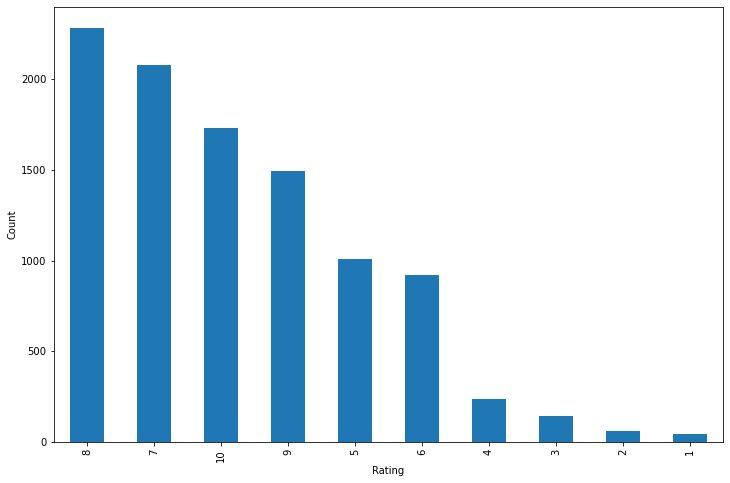

In [6]:
plt.figure(figsize=(12,8))
book["Book.Rating"].value_counts().plot(kind="bar")
plt.xlabel("Rating")
plt.ylabel("Count")


In [7]:
# checking number of unique users 

len(book["User.ID"].unique())

2182

In [8]:
# checking number of unique books 
len(book["Book.Title"].unique())

9659

#### Below are some basic observation on the book data

In [9]:
# Finding the best ranked books ( we will only keep rating more than 7)
pop_book=book[book["Book.Rating"] >7].sort_values("Book.Rating",ascending=False)
pop_book.head(20),pop_book.shape

(      User.ID                                         Book.Title  Book.Rating
 4879     2090   Scales of Justice (Return of the Dragon Fanuilh)           10
 3867     1254                                      Tango Finale.           10
 3872     1260                                      Der Virtuose.           10
 3879     1262  The story of the U.S.S. Arizona (Cornerstones ...           10
 3880     1262                                  Avalanche Soldier           10
 3883     1266                 The Burning Eye (Warworld, Book 1)           10
 3885     1279                                  Inherit the Stars           10
 3888     1293                              The Faded Sun Trilogy           10
 3892     1296     The Lottery Winner : Alvirah And Willy Stories           10
 3896     1297                                    Midnight Voices           10
 3898     1309                                           The Gift           10
 3899     1309                                    Se

In [10]:
# which book the user read the most( or which book recieved maximum number of ratings)
fav_books=book['Book.Title'].value_counts()
fav_books.head(10)


Fahrenheit 451                                     5
Charlie and the Chocolate Factory                  4
The Subtle Knife (His Dark Materials, Book 2)      4
Vanished                                           4
Ender's Game (Ender Wiggins Saga (Paperback))      4
Stardust                                           4
The Amber Spyglass (His Dark Materials, Book 3)    4
Life Is Elsewhere                                  3
The Golden Compass (His Dark Materials, Book 1)    3
The Hitchhiker's Guide to the Galaxy               3
Name: Book.Title, dtype: int64

In [11]:
# lets check the avg rating per book 
avg_rating=book[["Book.Title","Book.Rating"]].groupby("Book.Title").mean()
avg_rating

,Book.Rating
Book.Title,
"Jason, Madison &amp",8.0
Other Stories;Merril;1985;McClelland &amp,6.0
Repairing PC Drives &amp,4.0
'48,7.0
'O Au No Keia: Voices from Hawai'I's Mahu and Transgender Communities,8.0
...,...
"\Surely You're Joking, Mr. Feynman!\: Adventures of a Curious Character",8.0
"\Well, there's your problem\: Cartoons",9.0
iI Paradiso Degli Orchi,7.0


### Notes: 
#### User and product(books) are the 2 features that are important.Hence we will go for collaborative filtering (Memory based) with creating user item interaction matrix . Once the matrix is created , we will follow both item based and used based recomendation.

    -User based recomendation is for recomending books to other similar user based on a particular user

    -Item based is to find similar items or Finding the correlation with different books.

### creating pivot table to create User-Item iteration matrix

# User Based 

## #creating Pivot table with the data

In [12]:
# dropping duplicates first
book.drop_duplicates(keep=False,inplace=True)

In [13]:
book.shape

(9996, 3)

In [14]:
book.duplicated().value_counts()

False    9996
dtype: int64

In [15]:
book_pivot=pd.pivot_table(book,index= "User.ID",
                     columns="Book.Title",
                     values ="Book.Rating")

In [16]:
book_pivot.head()

Book.Title,"Jason, Madison &amp",Other Stories;Merril;1985;McClelland &amp,Repairing PC Drives &amp,'48,'O Au No Keia: Voices from Hawai'I's Mahu and Transgender Communities,...AND THE HORSE HE RODE IN ON : THE PEOPLE V. KENNETH STARR,01-01-00: A Novel of the Millennium,"1,401 More Things That P*Ss Me Off",10 Commandments Of Dating,"100 Great Fantasy Short, Short Stories",...,Zora Hurston and the Chinaberry Tree (Reading Rainbow Book),\Even Monkeys Fall from Trees\ and Other Japanese Proverbs,\I Won't Learn from You\: And Other Thoughts on Creative Maladjustment,"\More More More,\ Said the Baby",\O\ Is for Outlaw,"\Surely You're Joking, Mr. Feynman!\: Adventures of a Curious Character","\Well, there's your problem\: Cartoons",iI Paradiso Degli Orchi,stardust,Ã?Â?bermorgen.
User.ID,,,,,,,,,,,,,,,,,,,,,
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
#Impute those NaNs with 0 values
book_pivot.fillna(0, inplace=True)
book_pivot.head(10)

Book.Title,"Jason, Madison &amp",Other Stories;Merril;1985;McClelland &amp,Repairing PC Drives &amp,'48,'O Au No Keia: Voices from Hawai'I's Mahu and Transgender Communities,...AND THE HORSE HE RODE IN ON : THE PEOPLE V. KENNETH STARR,01-01-00: A Novel of the Millennium,"1,401 More Things That P*Ss Me Off",10 Commandments Of Dating,"100 Great Fantasy Short, Short Stories",...,Zora Hurston and the Chinaberry Tree (Reading Rainbow Book),\Even Monkeys Fall from Trees\ and Other Japanese Proverbs,\I Won't Learn from You\: And Other Thoughts on Creative Maladjustment,"\More More More,\ Said the Baby",\O\ Is for Outlaw,"\Surely You're Joking, Mr. Feynman!\: Adventures of a Curious Character","\Well, there's your problem\: Cartoons",iI Paradiso Degli Orchi,stardust,Ã?Â?bermorgen.
User.ID,,,,,,,,,,,,,,,,,,,,,
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Let's find cosine similarity 

    - there are 2 ways, we will apply both and compare to check if the data are same( for testing purpose only)

In [18]:
user_sim = 1 - pairwise_distances( book_pivot.values,metric='cosine')
user_sim,user_sim.shape

(array([[1., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 0., 1.]]),
 (2182, 2182))

#### Another way to derive is to apply cosine similarity directly 

In [19]:
user_sim1=cosine_similarity(book_pivot)
user_sim1,user_sim1.shape

(array([[1., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 0., 1.]]),
 (2182, 2182))

##### As we can see above both yielding same result. Storing one of the above in a dataframe.

In [20]:
# make the digonal "1" values to 0( as each record will have 100% against it)

np.fill_diagonal(user_sim1,0)
user_sim1


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [21]:
book_reco=pd.DataFrame(user_sim1)
book_reco

,0,1,2,3,4,5,6,7,8,9,...,2172,2173,2174,2175,2176,2177,2178,2179,2180,2181
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2177,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2178,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2179,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2180,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
#Set the index and column names to user ids 
book_reco.index=book_pivot.index
book_reco.columns=book_pivot.index

In [23]:
book_reco

User.ID,8,9,10,12,14,16,17,19,22,26,...,278831,278832,278836,278843,278844,278846,278849,278851,278852,278854
User.ID,,,,,,,,,,,,,,,,,,,,,
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278846,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
278849,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
278851,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
book_reco.sort_values([278846],ascending=False).head(100)

User.ID,8,9,10,12,14,16,17,19,22,26,...,278831,278832,278836,278843,278844,278846,278849,278851,278852,278854
User.ID,,,,,,,,,,,,,,,,,,,,,
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
161755,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
161744,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
161749,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
161750,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161441,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
161436,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
161434,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
#Finding Most Similar Users

pair=book_reco.idxmax(axis=1)[0:20]
pair

User.ID
8          8
9          8
10         8
12         8
14         8
16         8
17         8
19    278418
22         8
26         8
32         8
39         8
42         8
44         8
51      3757
53      1996
56         8
64         8
67         8
69         8
dtype: int64

In [26]:

book[book['User.ID']==9]
 

,User.ID,Book.Title,Book.Rating
2406,9,The Book of Kells: Selected Plates in Full Color,6


In [27]:
book[(book['User.ID']==9) | (book['User.ID']==161755)]

,User.ID,Book.Title,Book.Rating
2406,9,The Book of Kells: Selected Plates in Full Color,6
9283,161755,Katwalk (Kat Colorado Mysteries),9
9284,161755,Show of Evil,10
9285,161755,Y2K,9
9286,161755,Night Train to Memphis,5
9287,161755,Belladonna: A Novel of Revenge,9
9288,161755,The Simple Solution to Rubik's Cube,10
9289,161755,Suitable for Framing W/the Corpse Had a Famili...,6
9290,161755,CHINA WHITE,2
9291,161755,The Traveler,8


# Recomendation 

In [28]:
   '''
    Books recomendation to users step: 
    temp----> contains all the other users who are similar to user_id,
    book_list --> books rated by top users similar to user_id ( using top 2 user, can be increased to match req.)
    set(book_list)-all the books rated by all the user in temp 
    return value returns the books that are recomnded to the perticular user
    i.e 
    (all books rated by top 2 users - books rated by user_id)
    
    '''
def get_reco(user_id):
    temp=list(book_reco.sort_values([user_id],ascending=False).head(2).index)  
    book_list=list(book[book["User.ID"].isin(temp)]["Book.Title"])
    #print(movie_list)
    return set(book_list)-set(book[book["User.ID"]==user_id]["Book.Title"])

In [29]:
get_reco(22)

{'Ancient Celtic Romances',
 'Belladonna: A Novel of Revenge',
 'CHINA WHITE',
 'Daydreams',
 'Katwalk (Kat Colorado Mysteries)',
 'Keepers of the Earth Teachers Guide',
 'Night Train to Memphis',
 'Show of Evil',
 'Suitable for Framing W/the Corpse Had a Familiar Face',
 'The Art Of Celtia',
 'The Celts Activity Book',
 "The Simple Solution to Rubik's Cube",
 'The Traveler',
 'The Western way: A practical guide to the Western mystery tradition',
 'Truckers',
 'Wings',
 'Y2K'}

# Item Based Filtering 

In [30]:
item_pivot=book_pivot.T
item_pivot

User.ID,8,9,10,12,14,16,17,19,22,26,...,278831,278832,278836,278843,278844,278846,278849,278851,278852,278854
Book.Title,,,,,,,,,,,,,,,,,,,,,
"Jason, Madison &amp",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Other Stories;Merril;1985;McClelland &amp,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Repairing PC Drives &amp,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'48,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'O Au No Keia: Voices from Hawai'I's Mahu and Transgender Communities,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"\Surely You're Joking, Mr. Feynman!\: Adventures of a Curious Character",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"\Well, there's your problem\: Cartoons",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
iI Paradiso Degli Orchi,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0


In [31]:
item_sim=cosine_similarity(item_pivot)
item_reco=pd.DataFrame(item_sim,index=item_pivot.index,columns=item_pivot.index)
item_reco

Book.Title,"Jason, Madison &amp",Other Stories;Merril;1985;McClelland &amp,Repairing PC Drives &amp,'48,'O Au No Keia: Voices from Hawai'I's Mahu and Transgender Communities,...AND THE HORSE HE RODE IN ON : THE PEOPLE V. KENNETH STARR,01-01-00: A Novel of the Millennium,"1,401 More Things That P*Ss Me Off",10 Commandments Of Dating,"100 Great Fantasy Short, Short Stories",...,Zora Hurston and the Chinaberry Tree (Reading Rainbow Book),\Even Monkeys Fall from Trees\ and Other Japanese Proverbs,\I Won't Learn from You\: And Other Thoughts on Creative Maladjustment,"\More More More,\ Said the Baby",\O\ Is for Outlaw,"\Surely You're Joking, Mr. Feynman!\: Adventures of a Curious Character","\Well, there's your problem\: Cartoons",iI Paradiso Degli Orchi,stardust,Ã?Â?bermorgen.
Book.Title,,,,,,,,,,,,,,,,,,,,,
"Jason, Madison &amp",1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Other Stories;Merril;1985;McClelland &amp,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Repairing PC Drives &amp,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'48,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'O Au No Keia: Voices from Hawai'I's Mahu and Transgender Communities,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"\Surely You're Joking, Mr. Feynman!\: Adventures of a Curious Character",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
"\Well, there's your problem\: Cartoons",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
iI Paradiso Degli Orchi,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [32]:
values=item_reco.values
np.fill_diagonal(values,0)

In [33]:
item_reco

Book.Title,"Jason, Madison &amp",Other Stories;Merril;1985;McClelland &amp,Repairing PC Drives &amp,'48,'O Au No Keia: Voices from Hawai'I's Mahu and Transgender Communities,...AND THE HORSE HE RODE IN ON : THE PEOPLE V. KENNETH STARR,01-01-00: A Novel of the Millennium,"1,401 More Things That P*Ss Me Off",10 Commandments Of Dating,"100 Great Fantasy Short, Short Stories",...,Zora Hurston and the Chinaberry Tree (Reading Rainbow Book),\Even Monkeys Fall from Trees\ and Other Japanese Proverbs,\I Won't Learn from You\: And Other Thoughts on Creative Maladjustment,"\More More More,\ Said the Baby",\O\ Is for Outlaw,"\Surely You're Joking, Mr. Feynman!\: Adventures of a Curious Character","\Well, there's your problem\: Cartoons",iI Paradiso Degli Orchi,stardust,Ã?Â?bermorgen.
Book.Title,,,,,,,,,,,,,,,,,,,,,
"Jason, Madison &amp",0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Other Stories;Merril;1985;McClelland &amp,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Repairing PC Drives &amp,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'48,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'O Au No Keia: Voices from Hawai'I's Mahu and Transgender Communities,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"\Surely You're Joking, Mr. Feynman!\: Adventures of a Curious Character",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"\Well, there's your problem\: Cartoons",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
iI Paradiso Degli Orchi,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
# find the relation of books with each other 

book_pair=item_reco.idxmax(axis=1)[0:20]
book_pair

Book.Title
 Jason, Madison &amp                                                             Other Stories;Merril;1985;McClelland &amp
 Other Stories;Merril;1985;McClelland &amp                                                             Jason, Madison &amp
 Repairing PC Drives &amp                                                                              Jason, Madison &amp
'48                                                                      Angry Men, Passive Men: Understanding the Root...
'O Au No Keia: Voices from Hawai'I's Mahu and Transgender Communities                                A Child's Night Dream
...AND THE HORSE HE RODE IN ON : THE PEOPLE V. KENNETH STARR                                              11 Edward Street
01-01-00: A Novel of the Millennium                                             Alistair MacLean's Zeit der AttentÃ?Â¤ter.
1,401 More Things That P*Ss Me Off                                       3 Plays: Our Town, the Skin of Our Teeth, the ...
10 Co

In [35]:
# storing the books into a dataframe( optional, for better visibility purpose)
book_pair_df=pd.DataFrame(book_pair,columns=["Similar Books"])
book_pair_df

,Similar Books
Book.Title,
"Jason, Madison &amp",Other Stories;Merril;1985;McClelland &amp
Other Stories;Merril;1985;McClelland &amp,"Jason, Madison &amp"
Repairing PC Drives &amp,"Jason, Madison &amp"
'48,"Angry Men, Passive Men: Understanding the Root..."
'O Au No Keia: Voices from Hawai'I's Mahu and Transgender Communities,A Child's Night Dream
...AND THE HORSE HE RODE IN ON : THE PEOPLE V. KENNETH STARR,11 Edward Street
01-01-00: A Novel of the Millennium,Alistair MacLean's Zeit der AttentÃ?Â¤ter.
"1,401 More Things That P*Ss Me Off","3 Plays: Our Town, the Skin of Our Teeth, the ..."
10 Commandments Of Dating,A Ride into Morning: The Story of Tempe Wick


In [36]:

book[book['Book.Title']=='100 Great Fantasy Short, Short Stories' ]

,User.ID,Book.Title,Book.Rating
3656,1083,"100 Great Fantasy Short, Short Stories",10


In [37]:
book[(book['Book.Title']=='101 Dalmatians')|(book['Book.Title']=='30-Minute Meals')]


,User.ID,Book.Title,Book.Rating
626,277317,101 Dalmatians,9
7643,3827,30-Minute Meals,10
